## Goal: Meet a defined customer support service level (e.g., response-time SLA) while maximizing fairness and stability for the team, under a 4-day workweek, across time zones, and now with protected project time.

In [5]:
# If you're on Colab / fresh environment, run this first:
%pip -q install numpy pandas matplotlib scipy openpyxl reportlab

Note: you may need to restart the kernel to use updated packages.


In [20]:
# run this if you have Python < 3.10 version
from __future__ import annotations

# Helper Function: This is the “engine” (simulation + heuristic + optimization + exports).

In [4]:
import math
import random
import zlib
from dataclasses import dataclass
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DAYS = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
HOURS_PER_WEEK = 24 * 7


def make_hourly_frame() -> pd.DataFrame:
    rows = []
    for d in range(7):
        for h in range(24):
            rows.append({
                "day_index": d,
                "day": DAYS[d],
                "hour_utc": h,
                "hour_of_week": d * 24 + h
            })
    return pd.DataFrame(rows)


def simulate_required_coverage(total_agent_hours: int = 386, seed: int = 7) -> pd.DataFrame:
    """
    Simulate required staffing per hour (integer agents), calibrated so:
      sum(required_agents) == total_agent_hours

    This corresponds to the "386 hours of inbox coverage each week" number from the post.
    """
    rng = np.random.default_rng(seed)
    df = make_hourly_frame()

    # Day effects (Mon-Fri heavier, Sun lighter)
    day_mult = np.array([1.25, 1.15, 1.10, 1.10, 1.05, 0.85, 0.70])

    # Hour effects (two peaks)
    hour = df["hour_utc"].to_numpy()
    peak1 = np.exp(-0.5 * ((hour - 10) / 3.0) ** 2)
    peak2 = np.exp(-0.5 * ((hour - 18) / 4.0) ** 2)
    hour_shape = 0.6 + 0.9 * peak1 + 0.7 * peak2

    noise = rng.normal(loc=1.0, scale=0.12, size=len(df))
    weights = day_mult[df["day_index"].to_numpy()] * hour_shape * np.clip(noise, 0.6, 1.5)
    weights = np.clip(weights, 0.1, None)

    # Scale to target total hours
    scaled = weights / weights.sum() * total_agent_hours

    # Start with floor, enforce >=1 agent/hour, then adjust to match total
    req = np.floor(scaled).astype(int)
    req = np.maximum(req, 1)

    # If overshot due to minimums, subtract from smallest-weight hours while staying >=1
    while req.sum() > total_agent_hours:
        idx = np.argmin(weights + (req <= 1) * 1e9)
        if req[idx] > 1:
            req[idx] -= 1
        else:
            candidates = np.where(req > 1)[0]
            if len(candidates) == 0:
                break
            req[candidates[0]] -= 1

    # If under, add to largest residuals
    residual = scaled - np.floor(scaled)
    while req.sum() < total_agent_hours:
        idx = int(np.argmax(residual))
        req[idx] += 1
        residual[idx] = 0.0

    df["required_agents"] = req
    return df


@dataclass(frozen=True)
class Person:
    person_id: str
    role: str            # "Advocate" | "Lead"
    tz_offset: int       # integer hours from UTC (simplified)
    preferred_workblock: str  # "Mon-Thu" | "Tue-Fri" | "Other"


def build_team(seed: int = 7) -> list[Person]:
    """
    Simulated team: 14 Advocates + 4 Leads (VP excluded from coverage in this mockup).
    """
    random.seed(seed)
    tz_offsets = [-8, -7, -5, -4, 0, 1, 2, 3, 8, 10]  # 10 time zones

    people = []
    for i in range(14):
        pref = random.choices(["Mon-Thu", "Tue-Fri", "Other"], weights=[0.45, 0.45, 0.10])[0]
        people.append(Person(
            person_id=f"A{i+1:02d}",
            role="Advocate",
            tz_offset=random.choice(tz_offsets),
            preferred_workblock=pref
        ))

    for i in range(4):
        pref = random.choices(["Mon-Thu", "Tue-Fri", "Other"], weights=[0.35, 0.35, 0.30])[0]
        people.append(Person(
            person_id=f"L{i+1:02d}",
            role="Lead",
            tz_offset=random.choice(tz_offsets),
            preferred_workblock=pref
        ))

    return people


def enumerate_off_patterns() -> list[tuple[int, int, int]]:
    """
    3 off-days/week with at least 2 consecutive off-days.
    """
    patterns = []
    for a in range(7):
        for b in range(a + 1, 7):
            for c in range(b + 1, 7):
                off = sorted([a, b, c])
                consecutive = (off[1] == off[0] + 1) or (off[2] == off[1] + 1)
                if consecutive:
                    patterns.append((off[0], off[1], off[2]))
    return patterns


def workdays_from_off(off_days: tuple[int, int, int]) -> tuple[int, int, int, int]:
    off_set = set(off_days)
    work = [d for d in range(7) if d not in off_set]
    return (work[0], work[1], work[2], work[3])


def template_key(off_days: tuple[int, int, int], start_local: int) -> str:
    off_str = "-".join(DAYS[d] for d in off_days)
    return f"OFF[{off_str}]_START[{start_local:02d}:00]"


def role_inbox_hours(role: str) -> int:
    # Demo assumption:
    # - Advocates: 6 inbox hours per working day
    # - Leads:     3 inbox hours per working day
    return 6 if role == "Advocate" else (3 if role == "Lead" else 0)


def template_preference_penalty(person: Person, work_days: tuple[int, int, int, int]) -> float:
    work_set = set(work_days)
    if person.preferred_workblock == "Mon-Thu":
        return 0.0 if work_set == {0, 1, 2, 3} else 1.0
    if person.preferred_workblock == "Tue-Fri":
        return 0.0 if work_set == {1, 2, 3, 4} else 1.0
    return 0.25


def template_undesirable_off_penalty(off_days: tuple[int, int, int]) -> float:
    """
    A light proxy for the “midweek day off” problem.
    Real version would track history and enforce rotation fairness over time.
    """
    off = set(off_days)
    midweek = {2, 3}  # Wed, Thu
    if len(off.intersection(midweek)) >= 1 and len(off.intersection({5, 6})) == 0:
        return 0.25
    return 0.0


def _stable_seed_from_id(person_id: str, seed: int) -> int:
    # IMPORTANT: avoid Python's built-in hash() because it's randomized across sessions.
    return seed + (zlib.crc32(person_id.encode("utf-8")) % 10_000)


def build_templates_for_person(
    person: Person,
    off_patterns: list[tuple[int, int, int]],
    start_local_choices: list[int],
    top_k: int = 12,
    seed: int = 7,
) -> pd.DataFrame:
    """
    Create candidate templates for one person.
    Each template defines a 0/1 coverage vector for each hour of week (168 values).
    """
    rng = random.Random(_stable_seed_from_id(person.person_id, seed))

    rows = []
    for off_days in off_patterns:
        work_days = workdays_from_off(off_days)
        for start_local in start_local_choices:
            inbox_h = role_inbox_hours(person.role)
            cov = np.zeros(HOURS_PER_WEEK, dtype=int)

            for d in work_days:
                for k in range(inbox_h):
                    local_hour = start_local + k
                    utc_hour = (local_hour - person.tz_offset) % 24
                    hour_of_week = d * 24 + int(utc_hour)
                    cov[hour_of_week] = 1

            base_cost = (
                1.0 * template_preference_penalty(person, work_days)
                + 0.5 * template_undesirable_off_penalty(off_days)
                + rng.uniform(0, 0.02)  # tie-breaker
            )

            rows.append({
                "person_id": person.person_id,
                "role": person.role,
                "tz_offset": person.tz_offset,
                "off_days": off_days,
                "work_days": work_days,
                "start_local": start_local,
                "template_id": template_key(off_days, start_local),
                "base_cost": base_cost,
                "coverage_vec": cov
            })

    df = pd.DataFrame(rows).sort_values("base_cost", ascending=True).head(top_k).reset_index(drop=True)
    return df


def build_all_templates(people: list[Person], top_k: int = 12, seed: int = 7) -> dict[str, pd.DataFrame]:
    off_patterns = enumerate_off_patterns()
    start_local_choices = [9, 12, 15]
    templates = {}
    for p in people:
        templates[p.person_id] = build_templates_for_person(
            p, off_patterns=off_patterns, start_local_choices=start_local_choices, top_k=top_k, seed=seed
        )
    return templates


def heuristic_assign(
    people: list[Person],
    templates: dict[str, pd.DataFrame],
    required_agents: np.ndarray,
) -> dict[str, str]:
    """
    Greedy heuristic:
    - choose templates that reduce total undercoverage most
    - base_cost is a tie-breaker (preferences/fairness proxy)
    """
    capacity = np.zeros_like(required_agents)
    assignment = {}

    ordered = sorted(people, key=lambda p: 0 if p.role == "Advocate" else 1)

    for p in ordered:
        df = templates[p.person_id]
        best_tid = None
        best_score = float("inf")

        for _, row in df.iterrows():
            new_cap = capacity + row["coverage_vec"]
            under = np.maximum(0, required_agents - new_cap).sum()
            score = under * 1000 + row["base_cost"] * 10
            if score < best_score:
                best_score = score
                best_tid = row["template_id"]

        assignment[p.person_id] = best_tid
        chosen = df[df["template_id"] == best_tid].iloc[0]
        capacity = capacity + chosen["coverage_vec"]

    return assignment


def assignment_to_schedule_table(
    people: list[Person],
    templates: dict[str, pd.DataFrame],
    assignment: dict[str, str],
) -> pd.DataFrame:
    rows = []
    for p in people:
        df = templates[p.person_id]
        chosen = df[df["template_id"] == assignment[p.person_id]].iloc[0]
        off = chosen["off_days"]
        work = chosen["work_days"]

        rows.append({
            "person_id": p.person_id,
            "role": p.role,
            "tz_offset": p.tz_offset,
            "preferred_workblock": p.preferred_workblock,
            "template_id": chosen["template_id"],
            "start_local": int(chosen["start_local"]),
            "work_days": ",".join(DAYS[d] for d in work),
            "off_days": ",".join(DAYS[d] for d in off),
            "inbox_hours_per_day": role_inbox_hours(p.role),
        })

    return pd.DataFrame(rows).sort_values(["role", "person_id"]).reset_index(drop=True)


def compute_capacity_from_assignment(
    people: list[Person],
    templates: dict[str, pd.DataFrame],
    assignment: dict[str, str],
) -> np.ndarray:
    cap = np.zeros(HOURS_PER_WEEK, dtype=int)
    for p in people:
        df = templates[p.person_id]
        chosen = df[df["template_id"] == assignment[p.person_id]].iloc[0]
        cap += chosen["coverage_vec"]
    return cap


def milp_assign(
    people: list[Person],
    templates: dict[str, pd.DataFrame],
    required_agents: np.ndarray,
    under_weight: float = 1000.0,
    over_weight: float = 1.0,
    change_weight: float = 2.0,
    seed: int = 7,
) -> dict[str, str]:
    """
    MILP schedule selection (SciPy + HiGHS):
    - choose exactly 1 template per person
    - balance hourly coverage: sum(capacity) + u - o == required
    - heavily penalize undercoverage (u), lightly penalize overcoverage (o)
    - mild penalty for deviating from a simulated “baseline” schedule (stability proxy)
    """
    try:
        from scipy.optimize import milp, LinearConstraint, Bounds
        from scipy.sparse import csr_matrix
    except Exception as e:
        raise RuntimeError(
            "This cell needs SciPy with scipy.optimize.milp (SciPy >= 1.9). "
            "Try: %pip install -U scipy"
        ) from e

    # Simulated baseline: cheapest template per person
    baseline_template = {
        p.person_id: templates[p.person_id].sort_values("base_cost").iloc[0]["template_id"]
        for p in people
    }

    x_meta = []     # (person_id, template_id)
    cov_cols = []   # coverage vectors
    x_cost = []     # base_cost + change penalty

    for p in people:
        df = templates[p.person_id]
        for _, row in df.iterrows():
            x_meta.append((p.person_id, row["template_id"]))
            cov_cols.append(row["coverage_vec"])
            change_pen = 0.0 if row["template_id"] == baseline_template[p.person_id] else 1.0
            x_cost.append(float(row["base_cost"]) + change_weight * change_pen)

    n_x = len(x_meta)
    n_u = HOURS_PER_WEEK
    n_o = HOURS_PER_WEEK
    n_total = n_x + n_u + n_o

    c = np.zeros(n_total, dtype=float)
    c[:n_x] = np.array(x_cost)
    c[n_x:n_x+n_u] = under_weight
    c[n_x+n_u:] = over_weight

    integrality = np.zeros(n_total, dtype=int)
    integrality[:n_x] = 1  # binary x vars

    lb = np.zeros(n_total, dtype=float)
    ub = np.full(n_total, np.inf, dtype=float)
    ub[:n_x] = 1.0
    bounds = Bounds(lb, ub)

    # Build constraints:
    # 1) For each person: sum templates == 1
    # 2) For each hour: capacity + u - o == required
    rows, cols, data, b = [], [], [], []

    person_to_var_idxs = {}
    for j, (pid, tid) in enumerate(x_meta):
        person_to_var_idxs.setdefault(pid, []).append(j)

    row_idx = 0
    for pid, var_idxs in person_to_var_idxs.items():
        for j in var_idxs:
            rows.append(row_idx); cols.append(j); data.append(1.0)
        b.append(1.0)
        row_idx += 1

    cov_mat = np.vstack(cov_cols).astype(float)  # (n_x, 168)

    for h in range(HOURS_PER_WEEK):
        nonzero = np.where(cov_mat[:, h] != 0)[0]
        for j in nonzero:
            rows.append(row_idx); cols.append(int(j)); data.append(float(cov_mat[j, h]))

        # +u_h
        rows.append(row_idx); cols.append(n_x + h); data.append(1.0)
        # -o_h
        rows.append(row_idx); cols.append(n_x + n_u + h); data.append(-1.0)

        b.append(float(required_agents[h]))
        row_idx += 1

    A = csr_matrix((data, (rows, cols)), shape=(row_idx, n_total))
    b = np.array(b, dtype=float)

    constraints = LinearConstraint(A, lb=b, ub=b)  # equality constraints

    res = milp(c=c, integrality=integrality, bounds=bounds, constraints=constraints, options={"disp": False})
    if not res.success:
        raise RuntimeError(f"MILP failed: {res.message}")

    x_sol = res.x[:n_x]
    assignment = {}
    for pid, var_idxs in person_to_var_idxs.items():
        chosen_idx = max(var_idxs, key=lambda j: x_sol[j])
        assignment[pid] = x_meta[chosen_idx][1]

    return assignment


def allocate_project_blocks(
    people: list[Person],
    templates: dict[str, pd.DataFrame],
    assignment: dict[str, str],
    required_agents: np.ndarray,
    block_len_hours: int = 3,
    max_blocks_per_person: int = 1,
) -> pd.DataFrame:
    """
    Greedy allocation of project blocks:
    - Allocate only if removing coverage keeps capacity >= required for those hours
    - At most max_blocks_per_person per person
    """
    cap = compute_capacity_from_assignment(people, templates, assignment)
    surplus = cap - required_agents

    chosen_row = {}
    for p in people:
        df = templates[p.person_id]
        chosen_row[p.person_id] = df[df["template_id"] == assignment[p.person_id]].iloc[0]

    blocks = []
    blocks_count = {p.person_id: 0 for p in people}

    def sort_key(p: Person):
        return (blocks_count[p.person_id], 0 if p.role == "Advocate" else 1, p.person_id)

    made_progress = True
    while made_progress:
        made_progress = False
        for p in sorted(people, key=sort_key):
            if blocks_count[p.person_id] >= max_blocks_per_person:
                continue

            cov = chosen_row[p.person_id]["coverage_vec"]
            covered_hours = np.where(cov == 1)[0]

            best_candidate = None
            for d in range(7):
                day_hours = sorted([h for h in covered_hours if d * 24 <= h < (d + 1) * 24])
                if len(day_hours) < block_len_hours:
                    continue

                for idx in range(0, len(day_hours) - block_len_hours + 1):
                    window = day_hours[idx:idx + block_len_hours]
                    if window[-1] - window[0] != block_len_hours - 1:
                        continue
                    if np.all(surplus[window] >= 1):
                        best_candidate = (p.person_id, d, window[0] - d * 24, window)
                        break
                if best_candidate is not None:
                    break

            if best_candidate is None:
                continue

            pid, d, start_hour_in_day, window = best_candidate
            surplus[window] -= 1
            blocks_count[pid] += 1

            blocks.append({
                "person_id": pid,
                "day": DAYS[d],
                "start_hour_utc": int(start_hour_in_day),
                "length_hours": int(block_len_hours),
            })
            made_progress = True

    return pd.DataFrame(blocks).sort_values(["day", "start_hour_utc", "person_id"]).reset_index(drop=True)


def scale_required_agents(required_agents: np.ndarray, deflection_rate: float, min_required_per_hour: int = 1) -> np.ndarray:
    """
    Scale required agents by a deflection rate while keeping integers and preserving shape.
    Ensures total roughly matches round(total * (1 - deflection_rate)).
    """
    required_agents = required_agents.astype(int)
    scaled_cont = required_agents.astype(float) * (1 - deflection_rate)
    target_total = int(round(required_agents.sum() * (1 - deflection_rate)))

    base = np.floor(scaled_cont).astype(int)
    base = np.maximum(base, min_required_per_hour)

    if base.sum() < target_total:
        deficit = target_total - base.sum()
        residual = scaled_cont - np.floor(scaled_cont)
        idxs = np.argsort(-residual)  # descending
        i = 0
        while deficit > 0:
            base[idxs[i % len(idxs)]] += 1
            deficit -= 1
            i += 1

    elif base.sum() > target_total:
        surplus = base.sum() - target_total
        idxs = np.argsort(scaled_cont)  # ascending
        for h in idxs:
            if surplus == 0:
                break
            while base[h] > min_required_per_hour and surplus > 0:
                base[h] -= 1
                surplus -= 1

    return base


def what_if_project_blocks(
    required_agents: np.ndarray,
    capacity_agents: np.ndarray,
    rates: list[float] | None = None,
    min_required_per_hour: int = 1,
) -> pd.DataFrame:
    if rates is None:
        rates = [0.0, 0.05, 0.10, 0.15, 0.20, 0.30, 0.40]

    rows = []
    for r in rates:
        req_scaled = scale_required_agents(required_agents, r, min_required_per_hour=min_required_per_hour)
        surplus_hours = int(np.maximum(0, capacity_agents - req_scaled).sum())
        rows.append({
            "deflection_rate": r,
            "scaled_required_total": int(req_scaled.sum()),
            "total_surplus_agent_hours": surplus_hours
        })

    return pd.DataFrame(rows)


def coverage_summary(required: np.ndarray, capacity: np.ndarray) -> dict:
    under = np.maximum(0, required - capacity)
    over = np.maximum(0, capacity - required)
    return {
        "required_total": int(required.sum()),
        "capacity_total": int(capacity.sum()),
        "under_hours": int(under.sum()),
        "over_hours": int(over.sum()),
        "max_hourly_gap": int(under.max()),
    }


def plot_diff_heatmap(diff_168: np.ndarray, title: str):
    grid = diff_168.reshape(7, 24)
    plt.figure(figsize=(10, 3.2))
    plt.imshow(grid, aspect="auto")
    plt.colorbar(label="Capacity - Required (agents)")
    plt.yticks(range(7), DAYS)
    plt.xticks([0, 6, 12, 18, 23], ["0", "6", "12", "18", "23"])
    plt.title(title)
    plt.xlabel("Hour (UTC)")
    plt.ylabel("Day")
    plt.tight_layout()
    plt.show()


def save_diff_heatmap_png(diff_168: np.ndarray, title: str, out_png: Path):
    grid = diff_168.reshape(7, 24)
    plt.figure(figsize=(10, 3.2))
    plt.imshow(grid, aspect="auto")
    plt.colorbar(label="Capacity - Required (agents)")
    plt.yticks(range(7), DAYS)
    plt.xticks([0, 6, 12, 18, 23], ["0", "6", "12", "18", "23"])
    plt.title(title)
    plt.xlabel("Hour (UTC)")
    plt.ylabel("Day")
    plt.tight_layout()
    plt.savefig(out_png, dpi=200)
    plt.close()


def export_excel(
    out_xlsx: Path,
    required_df: pd.DataFrame,
    team_df: pd.DataFrame,
    heuristic_schedule: pd.DataFrame,
    optimized_schedule: pd.DataFrame,
    project_blocks: pd.DataFrame,
    whatif_df: pd.DataFrame,
):
    with pd.ExcelWriter(out_xlsx, engine="openpyxl") as writer:
        required_df.to_excel(writer, index=False, sheet_name="Required_Coverage")
        team_df.to_excel(writer, index=False, sheet_name="Team")
        heuristic_schedule.to_excel(writer, index=False, sheet_name="Heuristic_Schedule")
        optimized_schedule.to_excel(writer, index=False, sheet_name="Optimized_Schedule")
        project_blocks.to_excel(writer, index=False, sheet_name="Project_Blocks")
        whatif_df.to_excel(writer, index=False, sheet_name="What_If")


def export_pdf_simple(out_pdf: Path, images: list[Path], title: str = "Coverage & Project Time Mockup"):
    from reportlab.lib.pagesizes import letter
    from reportlab.pdfgen import canvas

    out_pdf.parent.mkdir(parents=True, exist_ok=True)
    c = canvas.Canvas(str(out_pdf), pagesize=letter)
    width, height = letter

    c.setFont("Helvetica-Bold", 16)
    c.drawString(40, height - 60, title)
    c.setFont("Helvetica", 10)
    c.drawString(40, height - 80, "Simulated data - inspired by public posts - demo only.")
    c.showPage()

    for img in images:
        c.setFont("Helvetica-Bold", 12)
        c.drawString(40, height - 40, img.stem.replace("_", " "))
        img_w = width - 80
        img_h = height - 120
        c.drawImage(str(img), 40, 60, width=img_w, height=img_h, preserveAspectRatio=True, anchor="c")
        c.showPage()

    c.save()

In [7]:
# Simulated hourly requirement (calibrated to 386 agent-hours/week)

SEED = 7

required_df = simulate_required_coverage(total_agent_hours=386, seed=SEED)
required = required_df["required_agents"].to_numpy()

print("Total required agent-hours/week:", required.sum())
required_df.head()

Total required agent-hours/week: 386


,day_index,day,hour_utc,hour_of_week,required_agents
0,0,Mon,0,0,1
1,0,Mon,1,1,2
2,0,Mon,2,2,1
3,0,Mon,3,3,1
4,0,Mon,4,4,2


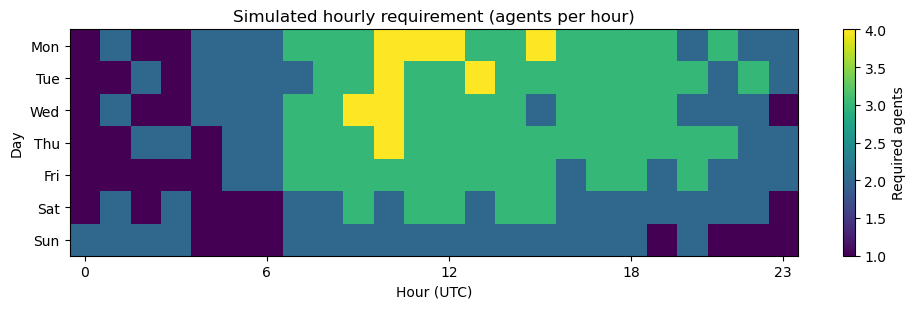

In [8]:
# Heatmap of required agents per hour (UTC)
req_grid = required.reshape(7, 24)

plt.figure(figsize=(10, 3.2))
plt.imshow(req_grid, aspect="auto")
plt.colorbar(label="Required agents")
plt.yticks(range(7), DAYS)
plt.xticks([0, 6, 12, 18, 23], ["0", "6", "12", "18", "23"])
plt.title("Simulated hourly requirement (agents per hour)")
plt.xlabel("Hour (UTC)")
plt.ylabel("Day")
plt.tight_layout()
plt.show()

In [10]:
# Team + schedule templates (4-day week patterns + time zones)

people = build_team(seed=SEED)
team_df = pd.DataFrame([p.__dict__ for p in people])

templates = build_all_templates(people, top_k=12, seed=SEED)

team_df.head(), team_df["role"].value_counts()

(  person_id      role  tz_offset preferred_workblock
 0       A01  Advocate         -5             Mon-Thu
 1       A02  Advocate         -8             Mon-Thu
 2       A03  Advocate          8             Mon-Thu
 3       A04  Advocate         10             Mon-Thu
 4       A05  Advocate          8             Mon-Thu,
 Advocate    14
 Lead         4
 Name: role, dtype: int64)

In [11]:
# Heuristic schedule (greedy)

heur_assign = heuristic_assign(people, templates, required)
heur_sched = assignment_to_schedule_table(people, templates, heur_assign)
cap_heur = compute_capacity_from_assignment(people, templates, heur_assign)

print("Heuristic summary:", coverage_summary(required, cap_heur))
heur_sched.head()

Heuristic summary: {'required_total': 386, 'capacity_total': 384, 'under_hours': 86, 'over_hours': 84, 'max_hourly_gap': 3}


,person_id,role,tz_offset,preferred_workblock,template_id,start_local,work_days,off_days,inbox_hours_per_day
0,A01,Advocate,-5,Mon-Thu,OFF[Fri-Sat-Sun]_START[15:00],15,"Mon,Tue,Wed,Thu","Fri,Sat,Sun",6
1,A02,Advocate,-8,Mon-Thu,OFF[Fri-Sat-Sun]_START[09:00],9,"Mon,Tue,Wed,Thu","Fri,Sat,Sun",6
2,A03,Advocate,8,Mon-Thu,OFF[Fri-Sat-Sun]_START[12:00],12,"Mon,Tue,Wed,Thu","Fri,Sat,Sun",6
3,A04,Advocate,10,Mon-Thu,OFF[Fri-Sat-Sun]_START[15:00],15,"Mon,Tue,Wed,Thu","Fri,Sat,Sun",6
4,A05,Advocate,8,Mon-Thu,OFF[Fri-Sat-Sun]_START[15:00],15,"Mon,Tue,Wed,Thu","Fri,Sat,Sun",6


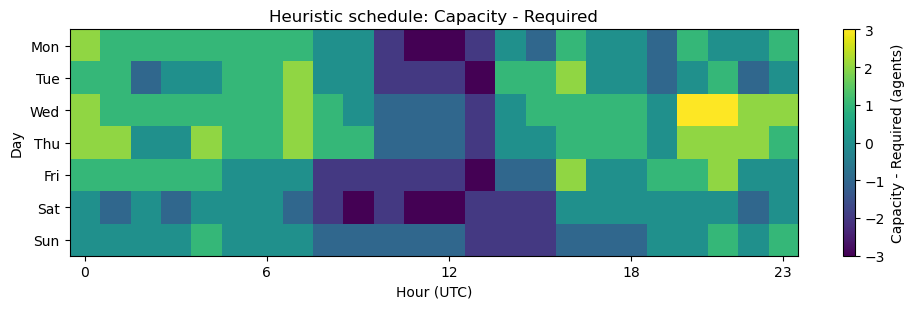

In [12]:
plot_diff_heatmap(cap_heur - required, "Heuristic schedule: Capacity - Required")

In [13]:
# Optimized schedule (MILP via SciPy/HiGHS)

opt_assign = milp_assign(people, templates, required, seed=SEED)
opt_sched = assignment_to_schedule_table(people, templates, opt_assign)
cap_opt = compute_capacity_from_assignment(people, templates, opt_assign)

print("Optimized summary:", coverage_summary(required, cap_opt))
opt_sched.head()

Optimized summary: {'required_total': 386, 'capacity_total': 384, 'under_hours': 48, 'over_hours': 46, 'max_hourly_gap': 4}


,person_id,role,tz_offset,preferred_workblock,template_id,start_local,work_days,off_days,inbox_hours_per_day
0,A01,Advocate,-5,Mon-Thu,OFF[Thu-Fri-Sun]_START[12:00],12,"Mon,Tue,Wed,Sat","Thu,Fri,Sun",6
1,A02,Advocate,-8,Mon-Thu,OFF[Mon-Tue-Sun]_START[09:00],9,"Wed,Thu,Fri,Sat","Mon,Tue,Sun",6
2,A03,Advocate,8,Mon-Thu,OFF[Wed-Thu-Sun]_START[15:00],15,"Mon,Tue,Fri,Sat","Wed,Thu,Sun",6
3,A04,Advocate,10,Mon-Thu,OFF[Mon-Tue-Sat]_START[15:00],15,"Wed,Thu,Fri,Sun","Mon,Tue,Sat",6
4,A05,Advocate,8,Mon-Thu,OFF[Mon-Fri-Sat]_START[15:00],15,"Tue,Wed,Thu,Sun","Mon,Fri,Sat",6


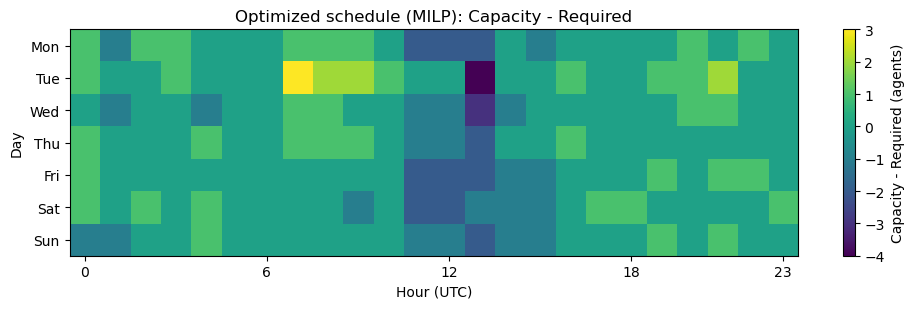

In [14]:
plot_diff_heatmap(cap_opt - required, "Optimized schedule (MILP): Capacity - Required")

In [15]:
# Project time blocks (allocated only in surplus windows)

project_blocks = allocate_project_blocks(
    people, templates, opt_assign, required,
    block_len_hours=3,        # half-day (demo simplification)
    max_blocks_per_person=1   # fairness cap
)

print("Project blocks allocated:", len(project_blocks))
project_blocks

Project blocks allocated: 5


,person_id,day,start_hour_utc,length_hours
0,A03,Mon,7,3
1,A04,Thu,7,3
2,A05,Tue,7,3
3,A08,Tue,7,3
4,A01,Tue,19,3


In [16]:
# What-if (demand deflection → more project capacity)

whatif_df = what_if_project_blocks(
    required_agents=required,
    capacity_agents=cap_opt,
    rates=[0.0, 0.05, 0.10, 0.15, 0.20, 0.30, 0.40]
)
whatif_df

,deflection_rate,scaled_required_total,total_surplus_agent_hours
0,0.00,386,46
1,0.05,367,70
2,0.10,347,79
3,0.15,328,96
4,0.20,309,107
5,0.30,270,141
6,0.40,232,163


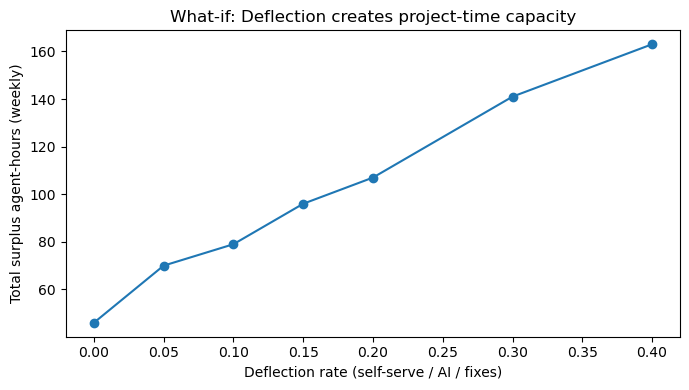

In [17]:
plt.figure(figsize=(7, 4))
plt.plot(whatif_df["deflection_rate"], whatif_df["total_surplus_agent_hours"], marker="o")
plt.xlabel("Deflection rate (self-serve / AI / fixes)")
plt.ylabel("Total surplus agent-hours (weekly)")
plt.title("What-if: Deflection creates project-time capacity")
plt.tight_layout()
plt.show()